## Setup enviroment

In [8]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import sys
sys.path.append(r'/home/jeanlr/projetos/lending-club/global')
from util import *
import gc
import json

## Read train parquet file

In [9]:
train_df = pd.read_parquet('../data/raw/lending_club_case_train_dataset.parquet')
train_df.info()
print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")
print(f"Max date: {train_df['issue_d'].max()}")
print(f"Min date: {train_df['issue_d'].min()}")

<class 'pandas.core.frame.DataFrame'>
Index: 1765426 entries, 0 to 2925491
Columns: 142 entries, id to default
dtypes: Int16(54), Int32(15), Int64(15), category(22), datetime64[ns](9), float16(23), float32(4)
memory usage: 1.0 GB
Memory usage: 1365.00 MB
Max date: 2017-12-01 00:00:00
Min date: 2007-06-01 00:00:00


## Verify the number of distinct loans per month

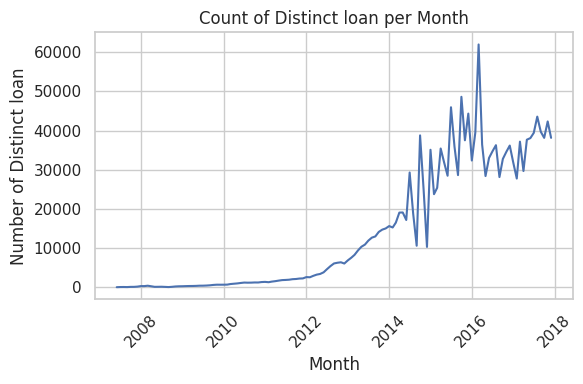

In [10]:
train_df['month'] = train_df['issue_d'].dt.to_period('M').dt.to_timestamp()
monthly_counts = train_df.groupby('month')['id'].nunique().reset_index()
plt.figure(figsize=(6, 4))
sns.lineplot(data=monthly_counts, x='month', y='id')
plt.xlabel('Month')
plt.ylabel('Number of Distinct loan')
plt.title('Count of Distinct loan per Month')
plt.xticks(rotation=45)
plt.tight_layout()

In [11]:
train_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,default,month
0,1077501,5000,5000,4976.0,36,0.106506,162.87500,B,B2,NaN,...,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0,2011-12-01
1,1077430,2500,2500,2500.0,60,0.152710,59.84375,C,C4,Ryder,...,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,1.0,2011-12-01
2,1077175,2400,2400,2400.0,36,0.159546,84.31250,C,C5,NaN,...,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0,2011-12-01
3,1076863,10000,10000,10000.0,36,0.134888,339.25000,C,C1,AIR RESOURCES BOARD,...,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0,2011-12-01
4,1075358,3000,3000,3000.0,60,0.126953,67.81250,B,B5,University Medical Group,...,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0,2011-12-01


## Read test parquet file

In [12]:
test_df = pd.read_parquet('../data/raw/lending_club_case_case_test_dataset.parquet')
test_df.info()
print(f"Memory usage: {test_df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")
print(f"Max date: {test_df['issue_d'].max()}")
print(f"Min date: {test_df['issue_d'].min()}")

<class 'pandas.core.frame.DataFrame'>
Index: 538826 entries, 472065 to 1082981
Columns: 141 entries, id to debt_settlement_flag
dtypes: Int16(54), Int32(15), Int64(15), category(22), datetime64[ns](9), float16(22), float32(4)
memory usage: 389.5 MB
Memory usage: 725.28 MB
Max date: 2019-01-01 00:00:00
Min date: 2018-01-01 00:00:00


## Monthly loans

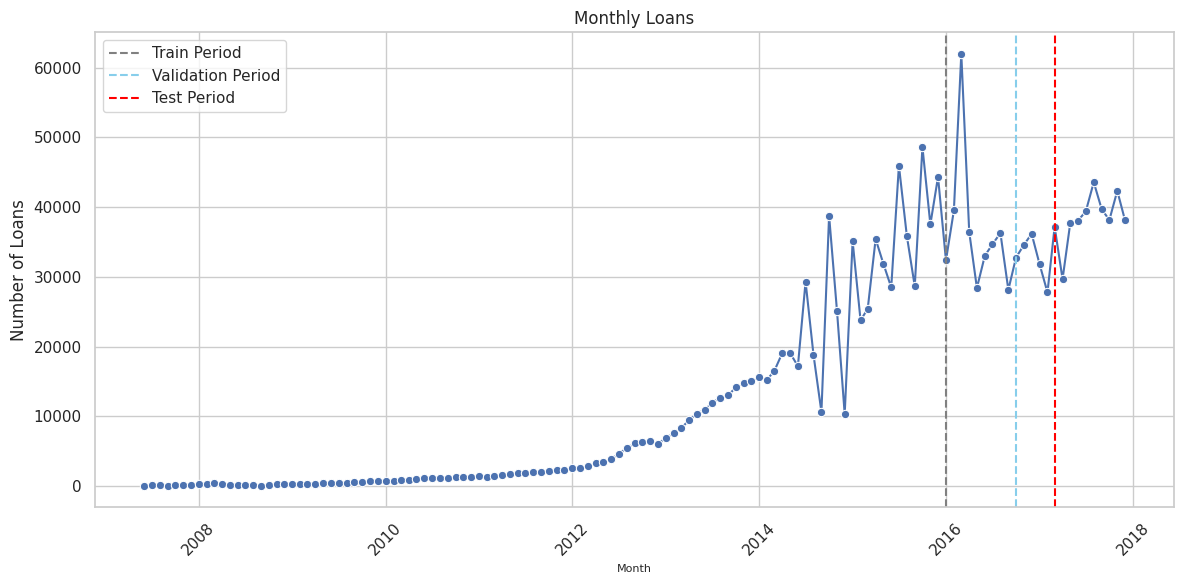

In [13]:
train_df['date_trunc_month'] = train_df['issue_d'].dt.to_period('M').dt.to_timestamp()
monthly_active_customers = train_df.groupby(train_df['date_trunc_month'])['id'].nunique().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_active_customers, x='date_trunc_month', y='id', marker='o')

plt.axvline(pd.Timestamp('2016-01-01'), color='gray', linestyle='--', label='Train Period')
plt.axvline(pd.Timestamp('2016-10-01'), color='skyblue', linestyle='--', label='Validation Period')
plt.axvline(pd.Timestamp('2017-03-01'), color='red', linestyle='--', label='Test Period')
plt.legend()

# Beautify the plot
plt.title('Monthly Loans', fontsize=12)
plt.xlabel('Month', fontsize=8)
plt.ylabel('Number of Loans', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

## Checking the variable of interest over time in the training table

In [14]:
train_df['issue_d'] = pd.to_datetime(train_df['issue_d'])
train_df['anomes'] = train_df['issue_d'].dt.strftime('%Y%m')
train_df['ano'] = train_df['issue_d'].dt.strftime('%Y')

In [15]:
resultado = train_df.groupby('ano').agg({'default': 'mean', 'ano': 'count'}).rename(columns={'ano': 'Volume'}).reset_index()
resultado.columns = ['Safra (AAAA)', 'Taxa_de_Evento', 'Volume']

# Exiba a tabela
resultado

,Safra (AAAA),Taxa_de_Evento,Volume
0,2007,0.179283,603
1,2008,0.158131,2393
2,2009,0.125954,5281
3,2010,0.128901,12537
4,2011,0.151789,21721
5,2012,0.161973,53367
6,2013,0.155970,134814
7,2014,0.177174,235629
8,2015,0.197841,421095
9,2016,0.196039,434407


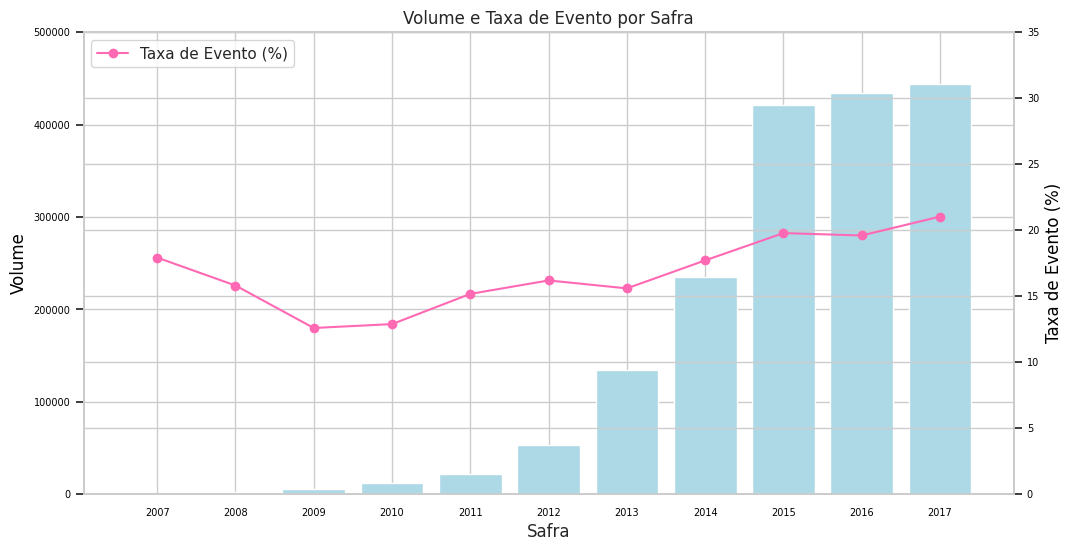

In [16]:
df_tx_evento = plot_tx_event_volume_safra(train_df,
                                              target='default',
                                              safra='ano',
                                              ymax_volume=500000, ymax_taxa_evento=35)